In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time
from glob import glob
import sys
sys.path.insert(0, '../')

In [5]:
from libra import nirspec_pixel_wavelengths, trappist1

In [6]:
wavelengths = wl = nirspec_pixel_wavelengths()

In [7]:
swl, _, _, sf = np.loadtxt('../libra/data/transmission/smart_spectra_trappist_co2_10bar_b.trnst', skiprows=10, unpack=True)

from scipy.optimize import fmin_powell

spitzer_wavelengths = np.array([3.6, 4.5])
spitzer_depths = 1e-2 * np.array([0.7070, 0.7277])
spitzer_errors = 1e-2 * np.array([0.0086, 0.0075])

# def get_scale_factor():
#     model = np.interp(spitzer_wavelengths, swl, sf)
#     X = model[:, np.newaxis]
#     Sigma = np.diag(spitzer_errors**2)
#     inv_sigma = np.linalg.inv(Sigma)
#     c = np.linalg.inv(X.T @ inv_sigma @ X) @ X.T @ inv_sigma @ spitzer_depths
 
#     return c[0]

def get_scale_factor(): 
    return fmin_powell(lambda x: np.sum((x*np.interp(spitzer_depths, swl, sf) - spitzer_depths)**2 / spitzer_errors**2), [1])

scale_factor = get_scale_factor()

Optimization terminated successfully.
         Current function value: 3.290761
         Iterations: 2
         Function evaluations: 48


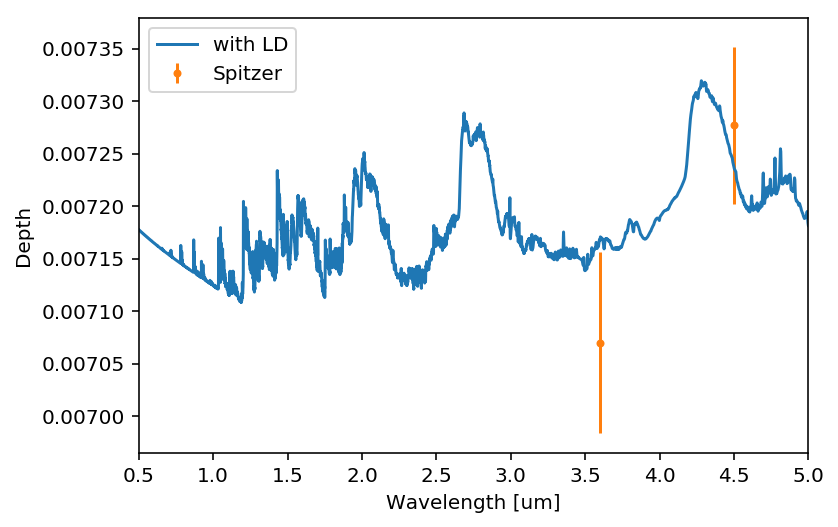

In [8]:
plt.plot(swl, sf * scale_factor, label='with LD')

plt.errorbar(spitzer_wavelengths, spitzer_depths,  spitzer_errors, fmt='.', label='Spitzer')
plt.xlabel('Wavelength [um]')
plt.ylabel('Depth')
plt.legend()
plt.xlim([0.5, 5])
plt.savefig('ld_correction.png', dpi=200, bbox_inches='tight')

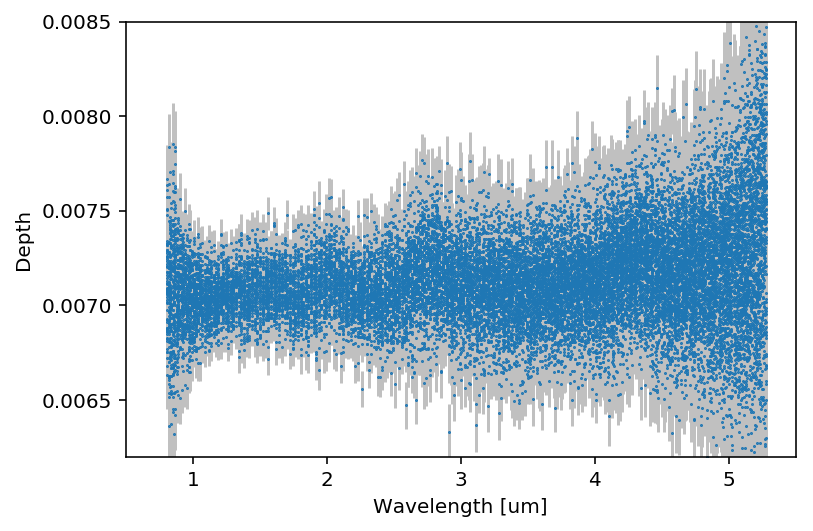

In [9]:
all_spectra = np.zeros(len(wavelengths))

all_spectra_errs = np.zeros(len(wavelengths))

swl, _, _, sf = np.loadtxt('../libra/data/transmission/smart_spectra_trappist_co2_10bar_b.trnst', skiprows=10, unpack=True)

sort = np.argsort(swl)
swl = swl[sort]
sf = sf[sort]

paths = glob('../outputs/cloud_free/transmission_*')
for i, path in enumerate(paths):
    w, f, e = np.loadtxt(path, unpack=True)
    if i == 0:
        all_spectra = f
        all_spectra_errors = e

    else: 
        all_spectra = np.vstack([all_spectra, f])
        all_spectra_errors = np.vstack([all_spectra_errors, e])
        
for i in range(all_spectra.shape[0]):
    plt.errorbar(w, all_spectra[i, :], all_spectra_errors[i, :], fmt='.', ms=1, ecolor='silver')

plt.xlim([0.5, 5.5])
plt.ylim([0.0062, 0.0085])
plt.xlabel('Wavelength [um]')
plt.ylabel('Depth')
plt.savefig('transmission.png', dpi=250, bbox_inches='tight')

In [10]:
from scipy.stats import chi2

In [11]:
chi2.sf(40, df=40)

0.47025726683923752

/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:740: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


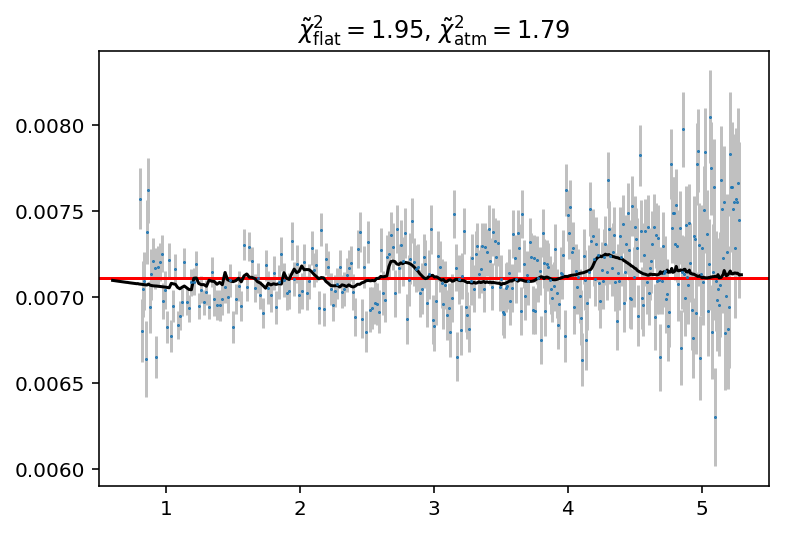

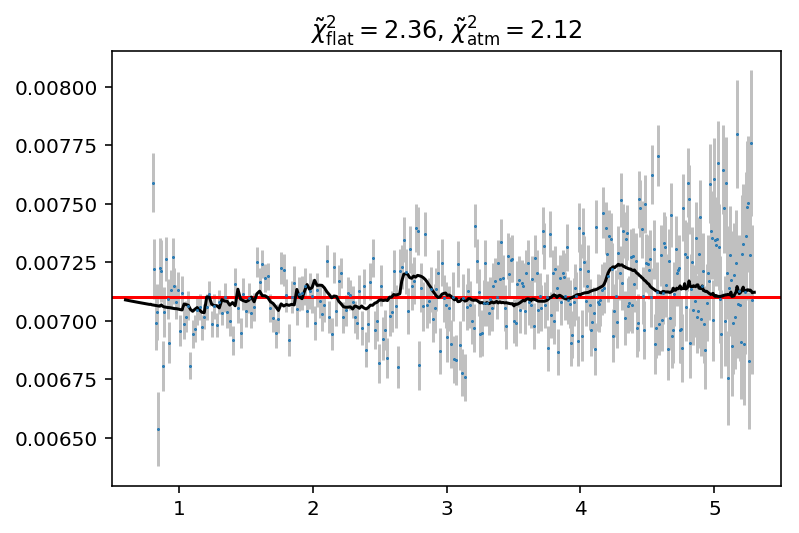

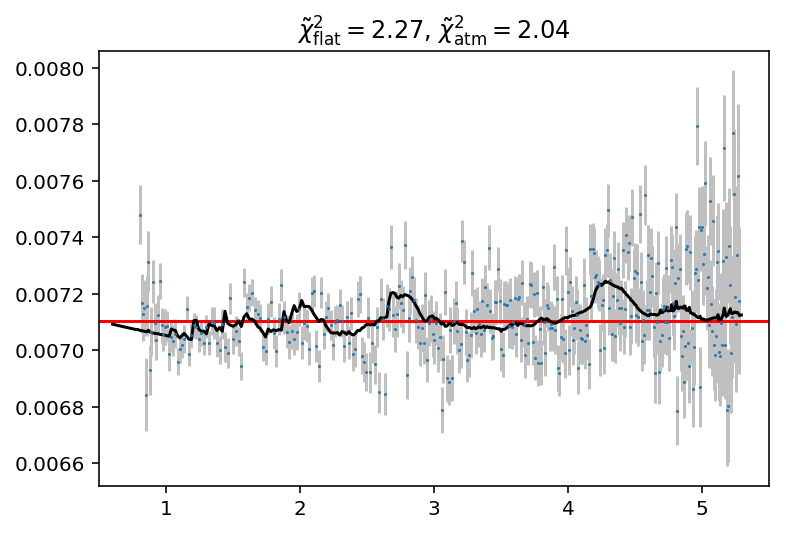

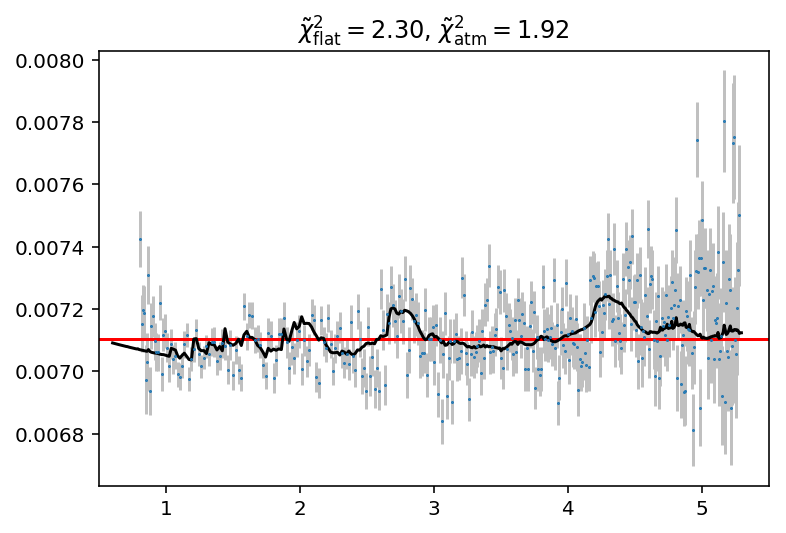

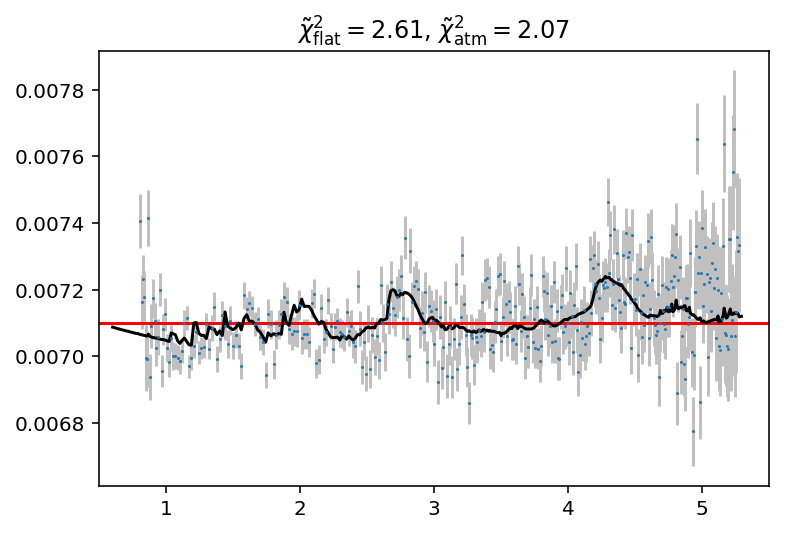

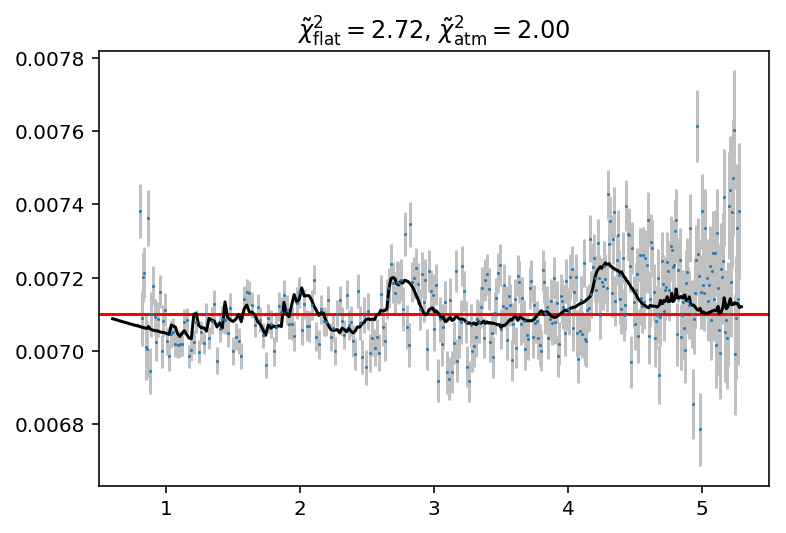

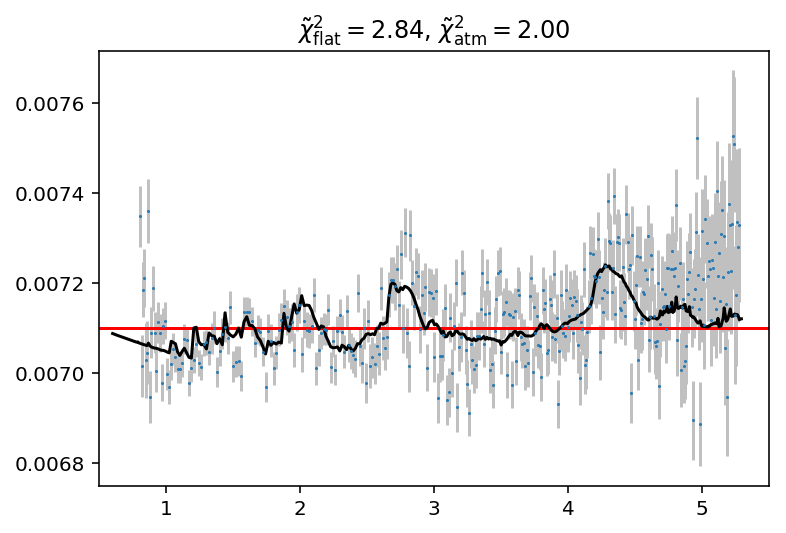

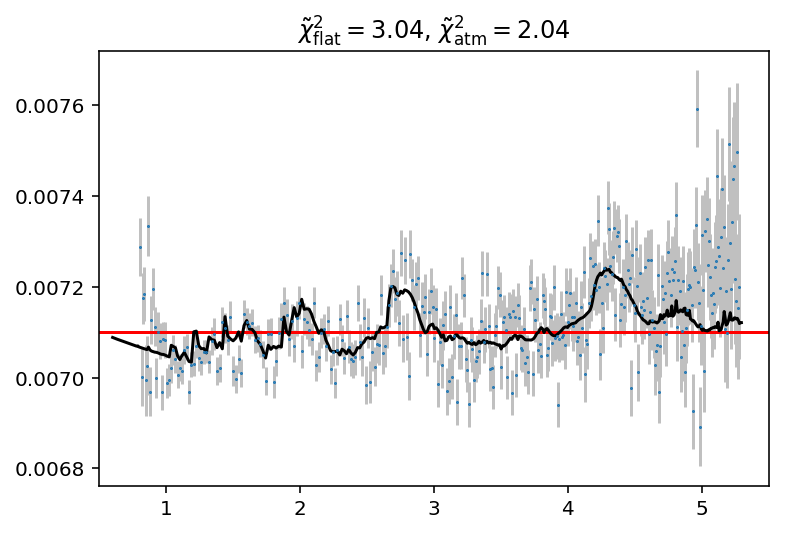

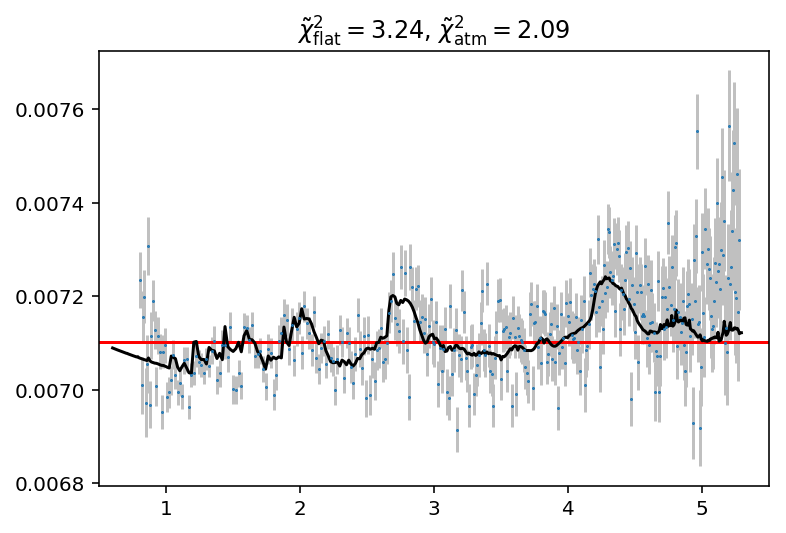

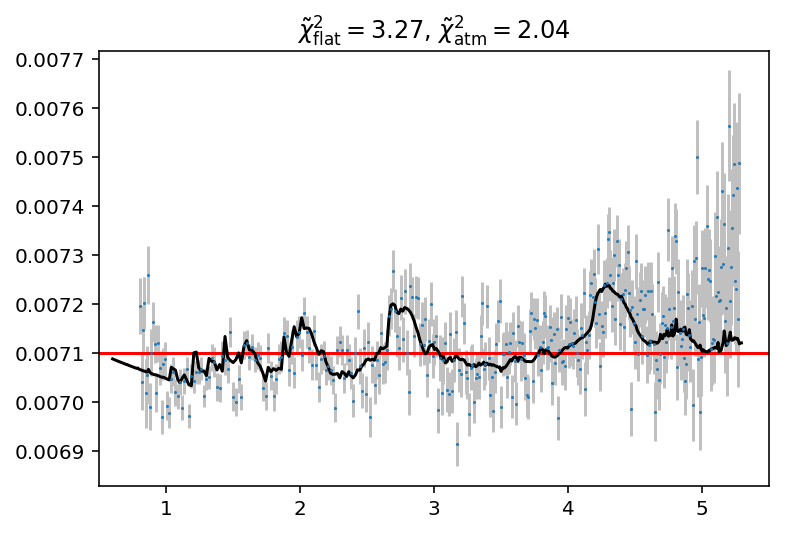

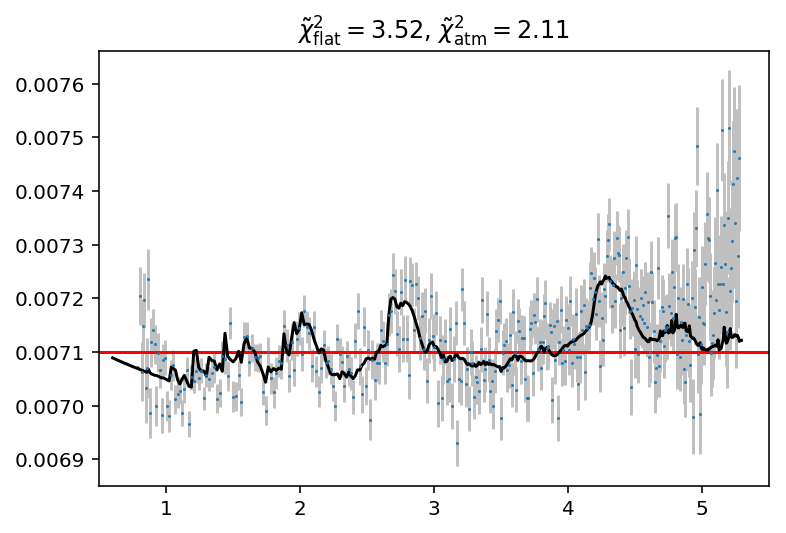

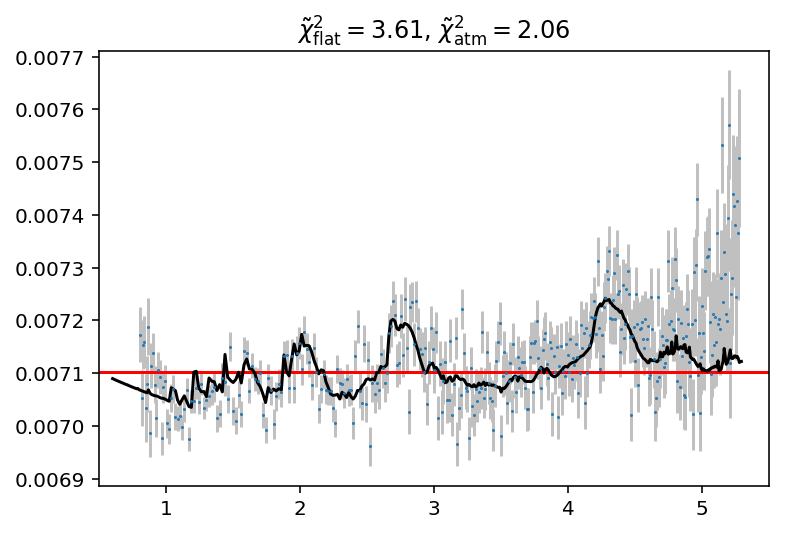

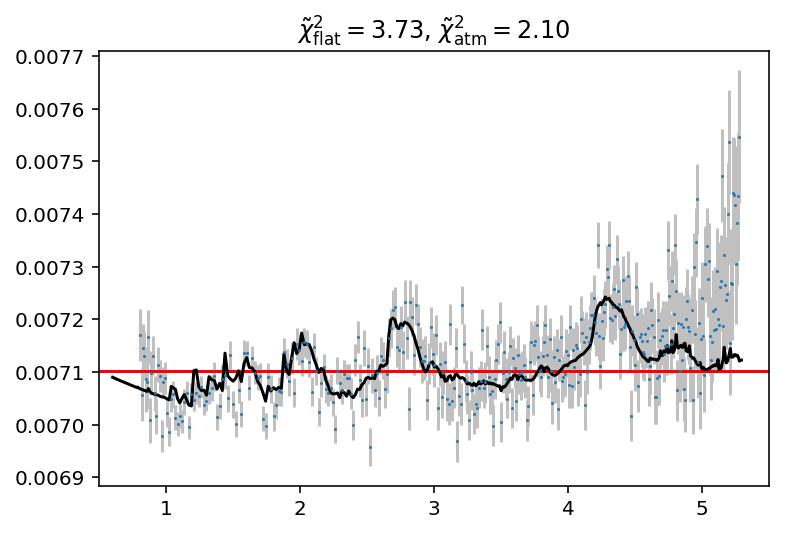

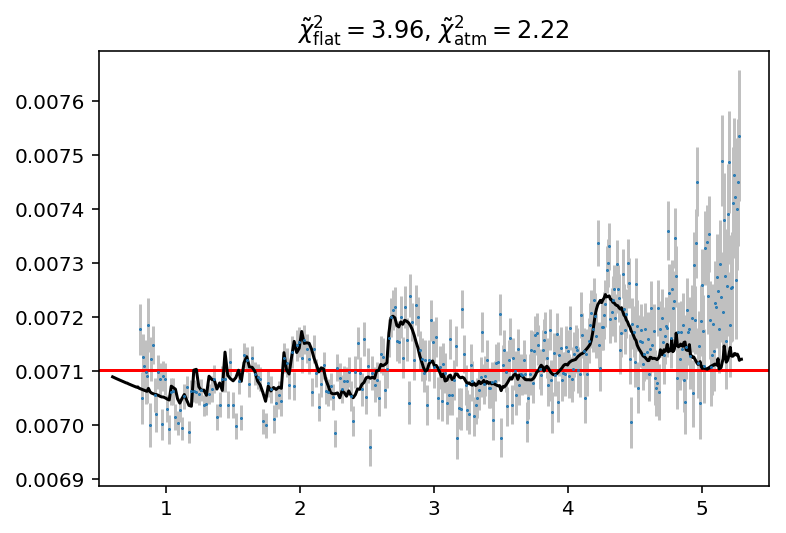

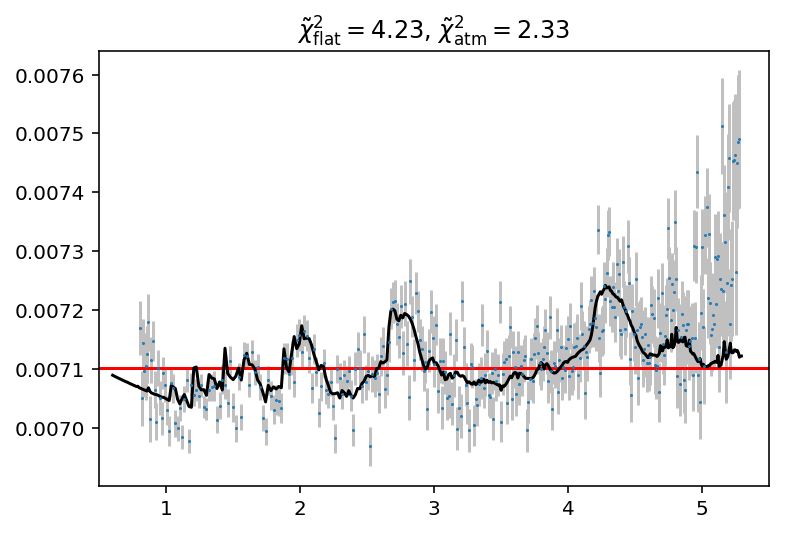

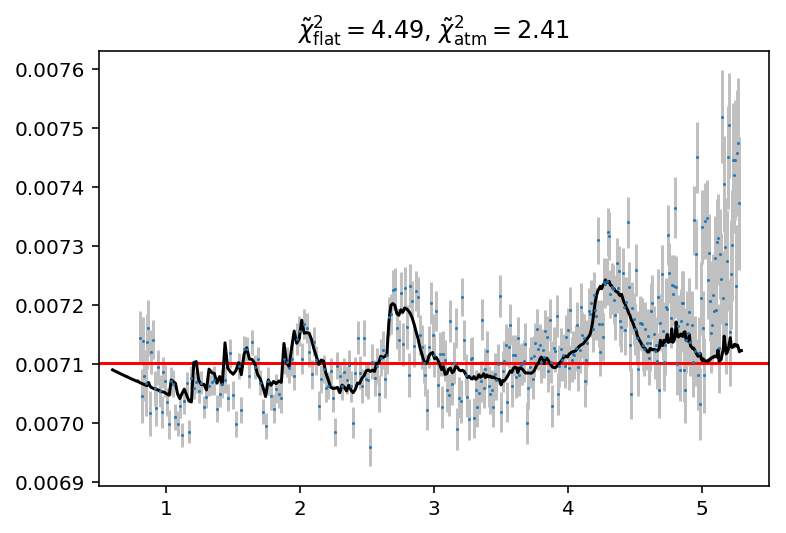

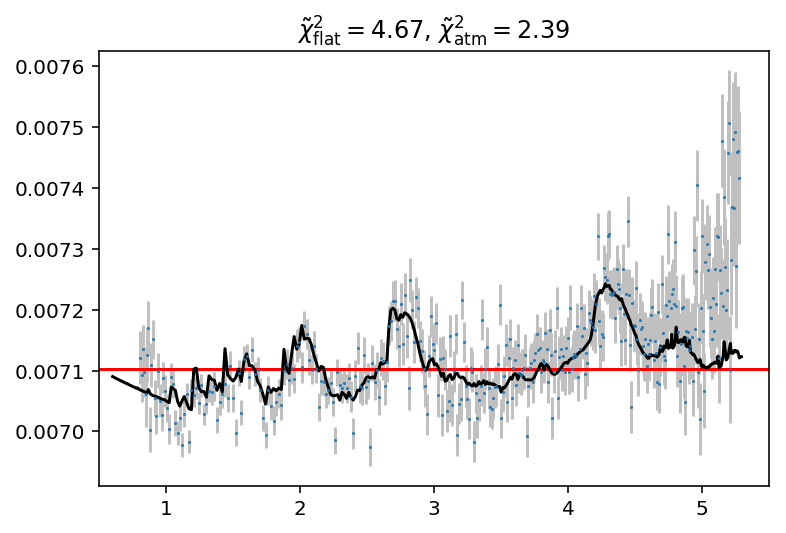

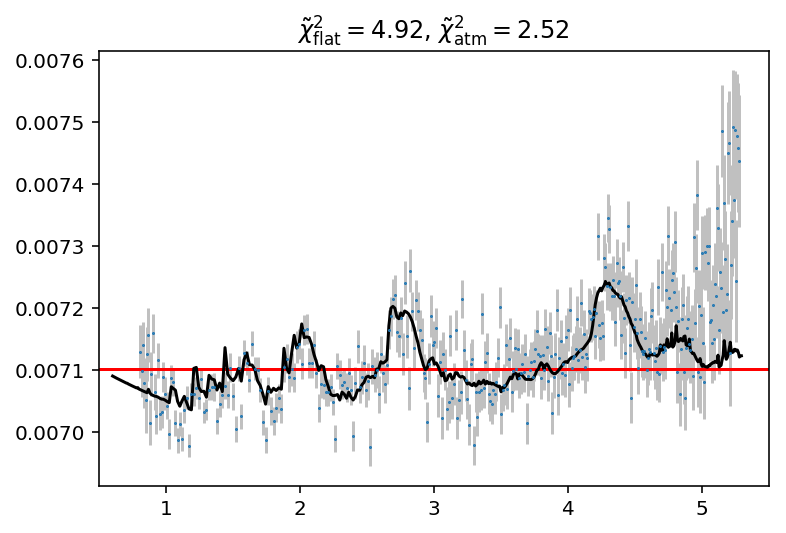

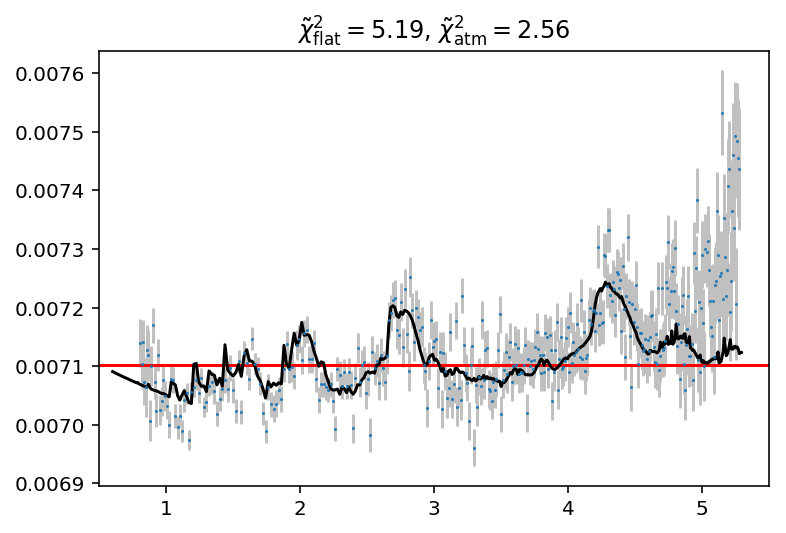

In [13]:
for i in range(1, 20):
    plt.figure()
    binned_spectrum = np.mean(all_spectra[0:i, :], axis=0)
    #binned_errors = np.sqrt(np.sum(all_spectra_errors[0:i*5, :]**2, axis=0) / all_spectra_errors[0:i*5, :].shape[0])
    binned_errors = np.nanmedian(all_spectra_errors[:, :], axis=0) / np.sqrt(all_spectra_errors[0:i, :].shape[0])
    
    # Must mask out nans
    mask = np.isnan(binned_spectrum)
    
    # Linear regression while properly accounting for uncertainties:
    X = np.ones((len(binned_spectrum[~mask]), 1))
    Sigma = np.diag(binned_errors[~mask]**2)
    inv_sigma = np.linalg.inv(Sigma)
    linear_model = np.linalg.inv(X.T @ inv_sigma @ X) @ X.T @ inv_sigma @ binned_spectrum[~mask]
    plt.axhline(linear_model, color='r')

    plt.errorbar(w, binned_spectrum, binned_errors, fmt='.', ms=1, ecolor='silver')

    X = np.interp(wl.value[~mask], swl, sf)[:, np.newaxis]
    Sigma = np.diag(binned_errors[~mask]**2)
    inv_sigma = np.linalg.inv(Sigma)
    c = np.linalg.inv(X.T @ inv_sigma @ X) @ X.T @ inv_sigma @ binned_spectrum[~mask]
    spectrum_model = np.interp(wl.value, swl, sf) * c
    plt.plot(wl, spectrum_model, color='k')

    chi2_linear = np.sum((binned_spectrum[~mask] - linear_model)**2 / binned_errors[~mask]**2)
    chi2_spectrum = np.sum((binned_spectrum[~mask] - spectrum_model[~mask])**2 / binned_errors[~mask]**2)

    likelihood_ratio = - 2 * (-0.5*chi2_linear - -0.5*chi2_spectrum)
    #p = chi2.sf(likelihood_ratio, df=len(binned_spectrum[~mask]))
    #plt.title("# transits = {1}, p = {0}".format(p, i))
    
    flat = r'$\tilde{{\chi}}^2_\mathrm{{flat}} = {0:.2f} $'.format(chi2_linear/len(binned_spectrum[~mask]))
    spectrum = r'$\tilde{{\chi}}^2_\mathrm{{atm}} = {0:.2f} $'.format(chi2_spectrum/len(binned_spectrum[~mask]))

    plt.title(flat + ', ' + spectrum)
    
    plt.xlim([0.5, 5.5])